# Quora Insincere Questions Classification
Detect toxic content to improve online conversations)

**Data fields**
* qid - unique question identifier
* question_text - Quora question text
* target - a question labeled "insincere" has a value of 1, otherwise 0

**Objective**: Explore the data and to build a simple model. In this competition by Quora, the objective is to predict whether a question asked on Quora is sincere or not. 

An insincere question is defined as a question intended to make a statement rather than look for helpful answers. Some characteristics that can signify that a question is insincere:

* Has a non-neutral tone
    * Has an exaggerated tone to underscore a point about a group of people
    * Is rhetorical and meant to imply a statement about a group of people
* Is disparaging or inflammatory
    * Suggests a discriminatory idea against a protected class of people, or seeks confirmation of a stereotype
    * Makes disparaging attacks/insults against a specific person or group of people
    * Based on an outlandish premise about a group of people
    * Disparages against a characteristic that is not fixable and not measurable
* Isn't grounded in reality
    * Based on false information, or contains absurd assumptions
* Uses sexual content (incest, bestiality, pedophilia) for shock value, and not to seek genuine answers

In [1]:
import os
import json
import string
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

%matplotlib inline

from plotly import tools  # to install $ pip install plotly
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go

from sklearn import model_selection, preprocessing, metrics, ensemble, naive_bayes, linear_model
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
import lightgbm as lgb # to install $ pip install lightgbm

pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 999

/Users/mk194903/anaconda3/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning:

Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.



In [2]:
train_df = pd.read_csv("dataset/quora-insincere/train.csv")
test_df = pd.read_csv("dataset/quora-insincere/test.csv")
print("Train shape : ", train_df.shape)
print("Test shape : ", test_df.shape)

Train shape :  (1306122, 3)
Test shape :  (56370, 2)


# Exploratory Data Analysis (EDA)

In [3]:
train_df.head()

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0


## Target Distribution:
First let us look at the distribution of the target variable to understand more about the imbalance and so on.

In [4]:
## target count ##
cnt_srs = train_df['target'].value_counts()
trace = go.Bar(
    x=cnt_srs.index,
    y=cnt_srs.values,
    marker=dict(
        color=cnt_srs.values,
        colorscale = 'Picnic',
        reversescale = True
    ),
)

layout = go.Layout(
    title='Target Count',
    font=dict(size=18)
)

data = [trace]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename="TargetCount")

## target distribution ##
labels = (np.array(cnt_srs.index))
sizes = (np.array((cnt_srs / cnt_srs.sum())*100))

trace = go.Pie(labels=labels, values=sizes)
layout = go.Layout(
    title='Target distribution',
    font=dict(size=18),
    width=600,
    height=600,
)
data = [trace]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename="usertype")


So about 6% of the training data are insincere questions (target=1) and rest of them are sincere.

## Word Cloud:
Now let us look at the frequently occuring words in the data by creating a word cloud on the 'question_text' column.

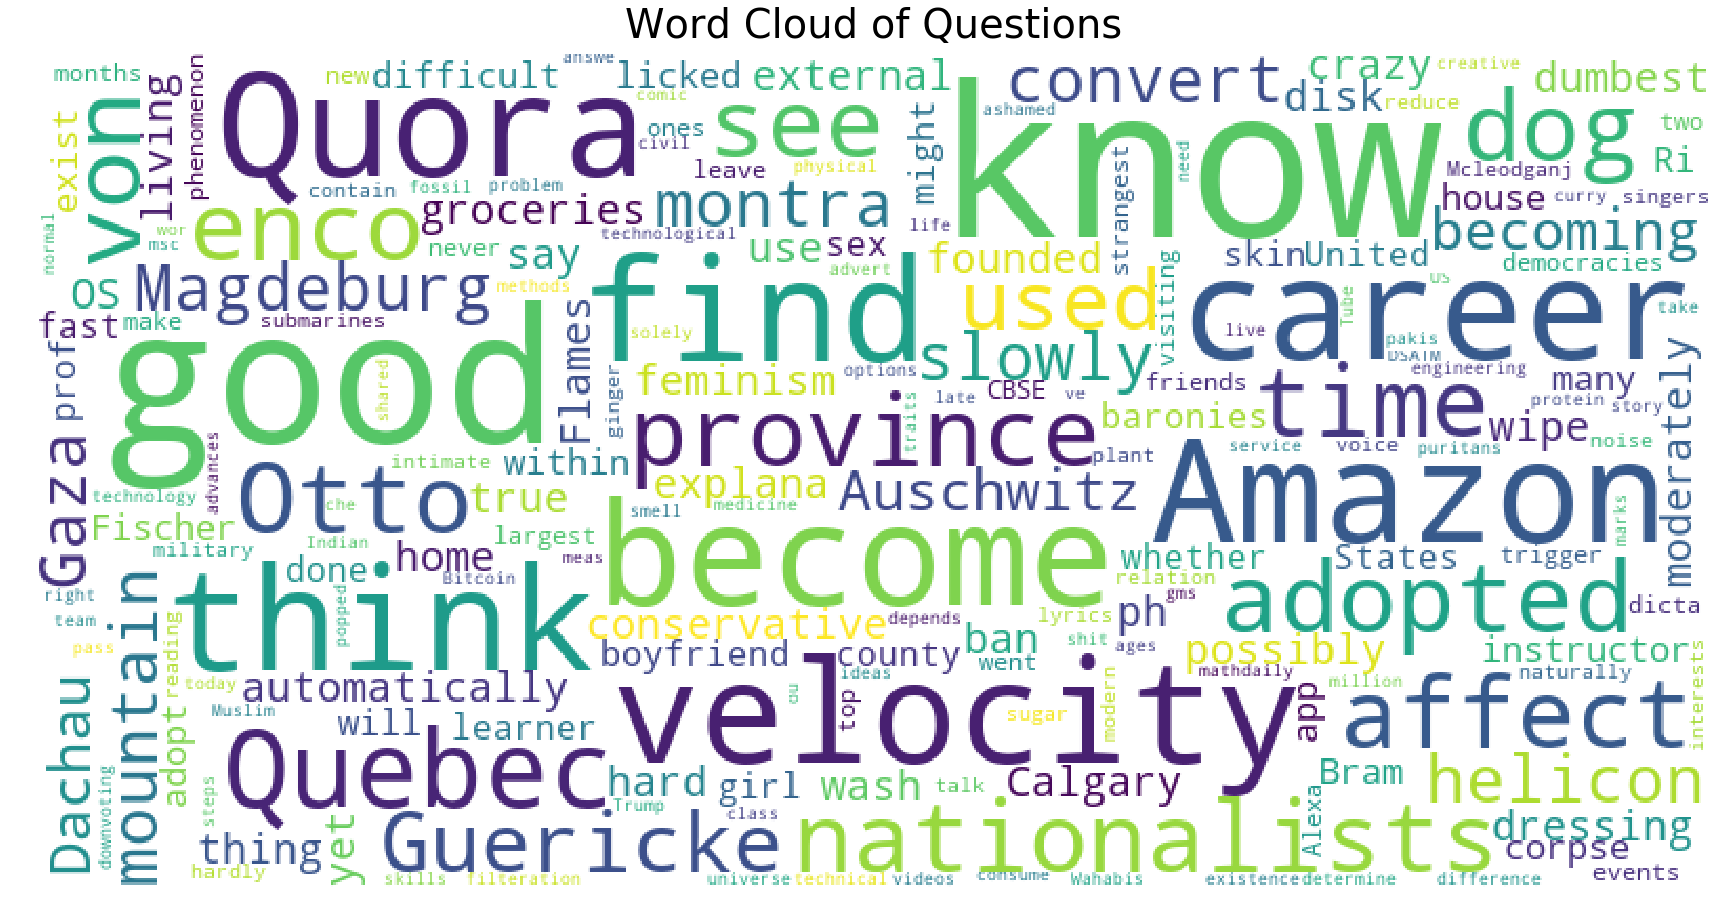

In [12]:
from wordcloud import WordCloud, STOPWORDS  #install $ pip install wordcloud

# Thanks : https://www.kaggle.com/aashita/word-clouds-of-various-shapes ##
def plot_wordcloud(text, mask=None, max_words=200, max_font_size=100, figure_size=(24.0,16.0), 
                   title = None, title_size=40, image_color=False):
    stopwords = set(STOPWORDS)
    more_stopwords = {'one', 'br', 'Po', 'th', 'sayi', 'fo', 'Unknown'}
    stopwords = stopwords.union(more_stopwords)

    wordcloud = WordCloud(background_color='white',
                    stopwords = stopwords,
                    max_words = max_words,
                    max_font_size = max_font_size, 
                    random_state = 42,
                    width=800, 
                    height=400,
                    mask = mask)
    wordcloud.generate(str(text))
    
    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,  
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': 'black', 
                                  'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()  
    
plot_wordcloud(train_df["question_text"], title="Word Cloud of Questions")

There seem to be a variety of words in there. May be it is a good idea to look at the most frequent words in each of the classes separately.

**Word Frequency plot of sincere & insincere questions:**

In [15]:
from collections import defaultdict
train1_df = train_df[train_df["target"]==1]
train0_df = train_df[train_df["target"]==0]

## custom function for ngram generation ##
def generate_ngrams(text, n_gram=1):
    token = [token for token in text.lower().split(" ") if token != "" if token not in STOPWORDS]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [" ".join(ngram) for ngram in ngrams]

## custom function for horizontal bar chart ##
def horizontal_bar_chart(df, color):
    trace = go.Bar(
        y=df["word"].values[::-1],
        x=df["wordcount"].values[::-1],
        showlegend=False,
        orientation = 'h',
        marker=dict(
            color=color,
        ),
    )
    return trace

In [17]:
## Get the bar chart from sincere questions ##
freq_dict = defaultdict(int)
for sent in train0_df["question_text"]:
    for word in generate_ngrams(sent, 1):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(50), 'blue')


## Get the bar chart from insincere questions ##
freq_dict = defaultdict(int)
for sent in train1_df["question_text"]:
    for word in generate_ngrams(sent, 1):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(50), 'blue')

# Creating two subplots
fig = tools.make_subplots(rows=1, cols=2, vertical_spacing=0.04,
                          subplot_titles=["Frequent words of sincere questions", 
                                          "Frequent words of insincere questions"])
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)
fig['layout'].update(height=1200, width=900, paper_bgcolor='rgb(233,233,233)', title="Word Count Plots")
py.iplot(fig, filename='word-plots')

#plt.figure(figsize=(10,16))
#sns.barplot(x="ngram_count", y="ngram", data=fd_sorted.loc[:50,:], color="b")
#plt.title("Frequent words for Insincere Questions", fontsize=16)
#plt.show()

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]



**Observations:**

* Some of the top words are common across both the classes like 'people', 'will', 'think' etc
* The other top words in sincere questions after excluding the common ones at the very top are 'best', 'good' etc
* The other top words in insincere questions after excluding the common ones are 'trump', 'women', 'white' etc <br>

**Now let us also create bigram frequency plots for both the classes separately to get more idea.**

In [14]:
freq_dict = defaultdict(int)
for sent in train0_df["question_text"]:
    for word in generate_ngrams(sent,2):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(50), 'orange')


freq_dict = defaultdict(int)
for sent in train1_df["question_text"]:
    for word in generate_ngrams(sent,2):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(50), 'orange')

# Creating two subplots
fig = tools.make_subplots(rows=1, cols=2, vertical_spacing=0.04,horizontal_spacing=0.15,
                          subplot_titles=["Frequent bigrams of sincere questions", 
                                          "Frequent bigrams of insincere questions"])
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)
fig['layout'].update(height=1200, width=900, paper_bgcolor='rgb(233,233,233)', title="Bigram Count Plots")
py.iplot(fig, filename='word-plots')

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]



**Observations:**

* We can see insincere questions are targating specific people, race or age.

**Now let's usl look at the trigram plots as well.**

In [18]:
freq_dict = defaultdict(int)
for sent in train0_df["question_text"]:
    for word in generate_ngrams(sent,3):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(50), 'green')


freq_dict = defaultdict(int)
for sent in train1_df["question_text"]:
    for word in generate_ngrams(sent,3):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(50), 'green')

# Creating two subplots
fig = tools.make_subplots(rows=1, cols=2, vertical_spacing=0.04, horizontal_spacing=0.2,
                          subplot_titles=["Frequent trigrams of sincere questions", 
                                          "Frequent trigrams of insincere questions"])
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)
fig['layout'].update(height=1200, width=1200, paper_bgcolor='rgb(233,233,233)', title="Trigram Count Plots")
py.iplot(fig, filename='word-plots')

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]



**Observations:**

We can see insincere questions are targating specific people, race or age.

## Meta Features:

Now let us create some meta features and then look at how they are distributed between the classes. The ones that we will create are

1. Number of words in the text
2. Number of unique words in the text
3. Number of characters in the text
4. Number of stopwords
5. Number of punctuations
6. Number of upper case words
7. Number of title case words
8. Average length of the words

In [19]:
## Number of words in the text ##
train_df["num_words"] = train_df["question_text"].apply(lambda x: len(str(x).split()))
test_df["num_words"] = test_df["question_text"].apply(lambda x: len(str(x).split()))

## Number of unique words in the text ##
train_df["num_unique_words"] = train_df["question_text"].apply(lambda x: len(set(str(x).split())))
test_df["num_unique_words"] = test_df["question_text"].apply(lambda x: len(set(str(x).split())))

## Number of characters in the text ##
train_df["num_chars"] = train_df["question_text"].apply(lambda x: len(str(x)))
test_df["num_chars"] = test_df["question_text"].apply(lambda x: len(str(x)))

## Number of stopwords in the text ##
train_df["num_stopwords"] = train_df["question_text"].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))
test_df["num_stopwords"] = test_df["question_text"].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))

## Number of punctuations in the text ##
train_df["num_punctuations"] =train_df['question_text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]) )
test_df["num_punctuations"] =test_df['question_text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]) )

## Number of title case words in the text ##
train_df["num_words_upper"] = train_df["question_text"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))
test_df["num_words_upper"] = test_df["question_text"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))

## Number of title case words in the text ##
train_df["num_words_title"] = train_df["question_text"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))
test_df["num_words_title"] = test_df["question_text"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))

## Average length of the words in the text ##
train_df["mean_word_len"] = train_df["question_text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
test_df["mean_word_len"] = test_df["question_text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

**Now let us see how these meta features are distributed between both sincere and insincere questions.**

/Users/mk194903/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



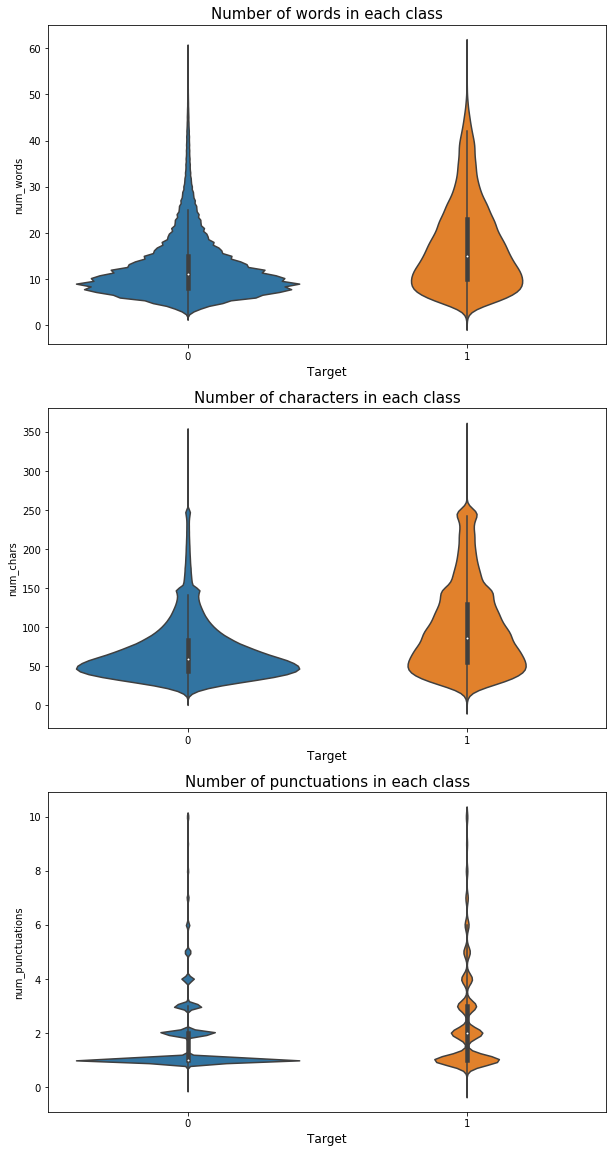

In [37]:
## Truncate some extreme values for better visuals ##
train_df['num_words'].loc[train_df['num_words']>60] = 60 #truncation for better visuals
train_df['num_punctuations'].loc[train_df['num_punctuations']>10] = 10 #truncation for better visuals
train_df['num_chars'].loc[train_df['num_chars']>350] = 350 #truncation for better visuals

f, axes = plt.subplots(3, 1, figsize=(10,20))
sns.violinplot(x='target', y='num_words', data=train_df, ax=axes[0])
axes[0].set_xlabel('Target', fontsize=12)
axes[0].set_title("Number of words in each class", fontsize=15)

sns.violinplot(x='target', y='num_chars', data=train_df, ax=axes[1])
axes[1].set_xlabel('Target', fontsize=12)
axes[1].set_title("Number of characters in each class", fontsize=15)

sns.violinplot(x='target', y='num_punctuations', data=train_df, ax=axes[2])
axes[2].set_xlabel('Target', fontsize=12)
#plt.ylabel('Number of punctuations in text', fontsize=12)
axes[2].set_title("Number of punctuations in each class", fontsize=15)
plt.show()

**Inference:**

We can see that the insincere questions have more number of words as well as characters compared to sincere questions. So this might be a useful feature in our model.

## Visualizing Word Vectors

In [45]:
import nltk
import re

from gensim.models import word2vec
from sklearn.manifold import TSNE

In [43]:

STOP_WORDS = nltk.corpus.stopwords.words()

def clean_sentence(val):
    "remove chars that are not letters or numbers, downcase, then remove stop words"
    regex = re.compile('([^\s\w]|_)+')
    sentence = regex.sub('', val).lower()
    sentence = sentence.split(" ")
    
    for word in list(sentence):
        if word in STOP_WORDS:
            sentence.remove(word)  
            
    sentence = " ".join(sentence)
    return sentence

def clean_dataframe(data):
    "drop nans, then apply 'clean_sentence' function to question1 and 2"
    data = data.dropna(how="any")
    data["question_text"] = data["question_text"].apply(clean_sentence)
    
    return data

In [44]:
data = clean_dataframe(train_df)
data.head(5)

,qid,question_text,target,num_words,num_unique_words,num_chars,num_stopwords,num_punctuations,num_words_upper,num_words_title,mean_word_len
0,00002165364db923c7e6,quebec nationalists see province nation 1960s,0,13,13,72,7,1,0,2,4.615385
1,000032939017120e6e44,adopted would encourage people adopt shop,0,16,15,81,10,2,0,1,4.125000
2,0000412ca6e4628ce2cf,velocity affect time velocity affect space geo...,0,10,8,67,3,2,0,2,5.800000
3,000042bf85aa498cd78e,otto guericke used magdeburg hemispheres,0,9,9,57,3,1,0,4,5.444444
4,0000455dfa3e01eae3af,convert montra helicon mountain bike changing ...,0,15,15,77,7,1,2,3,4.200000


In [46]:
def build_corpus(data):
    "Creates a list of lists containing words from each sentence"
    corpus = []
    for sentence in data["question_text"].iteritems():
        word_list = sentence[1].split(" ")
        corpus.append(word_list)
            
    return corpus

In [47]:
corpus = build_corpus(data)        
corpus[0:2]

[['quebec', 'nationalists', 'see', 'province', 'nation', '1960s'],
 ['adopted', 'would', 'encourage', 'people', 'adopt', 'shop']]

In [48]:
def tsne_plot(model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

/Users/mk194903/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).



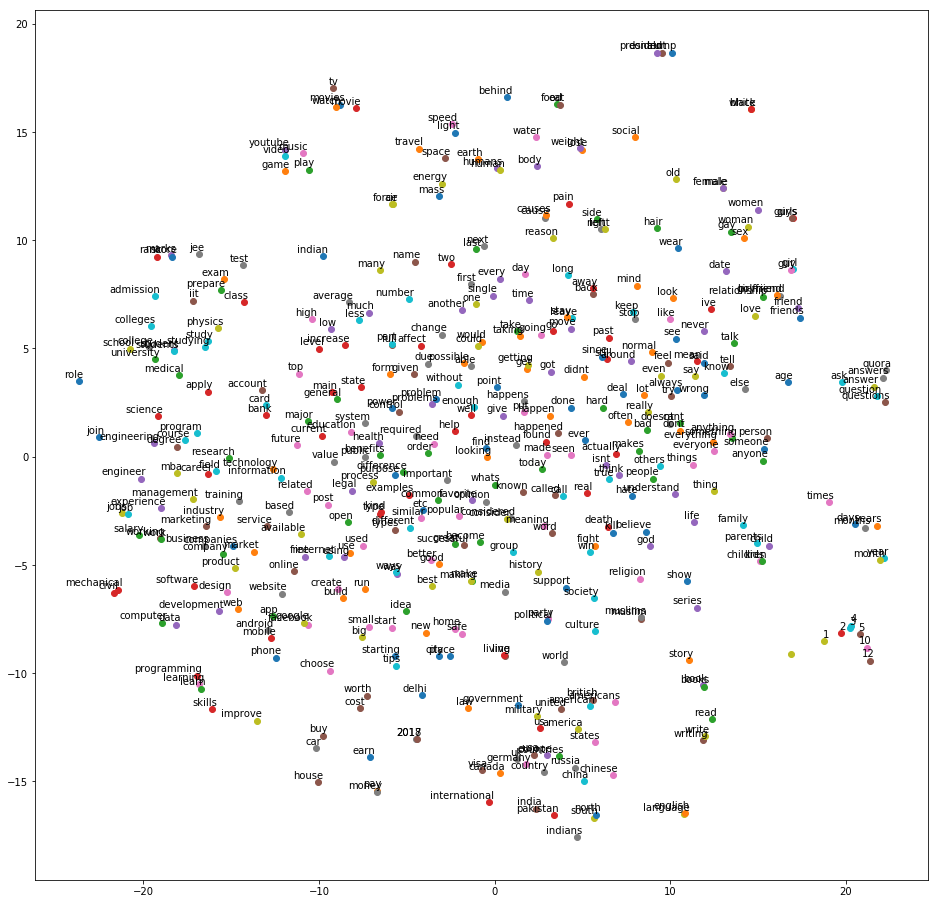

In [56]:
model = word2vec.Word2Vec(corpus, size=100, window=20, min_count=3000, workers=4)
tsne_plot(model)

In [53]:
model.most_similar('phone')

/Users/mk194903/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning:

Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).

/Users/mk194903/anaconda3/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning:

Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.



[('phones', 0.7415003776550293),
 ('iphone', 0.6686872243881226),
 ('device', 0.6666756868362427),
 ('messages', 0.6659635305404663),
 ('samsung', 0.6481708288192749),
 ('whatsapp', 0.6397003531455994),
 ('mobile', 0.6309661865234375),
 ('text', 0.5890854001045227),
 ('message', 0.5728951692581177),
 ('screen', 0.5669472217559814)]

In [54]:
model.most_similar('trump')

/Users/mk194903/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning:

Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).

/Users/mk194903/anaconda3/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning:

Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.



[('trumps', 0.8825075030326843),
 ('obama', 0.7994542121887207),
 ('democrats', 0.768091082572937),
 ('republicans', 0.7075307369232178),
 ('hillary', 0.6938848495483398),
 ('clinton', 0.6873109936714172),
 ('president', 0.6699155569076538),
 ('liberals', 0.6109368801116943),
 ('conservatives', 0.5698452591896057),
 ('russia', 0.5556876063346863)]

# Baseline Model:

To start with, let us just build a baseline model (Logistic Regression) with TFIDF vectors.

In [21]:
# Get the tfidf vectors #
tfidf_vec = TfidfVectorizer(stop_words='english', ngram_range=(1,3))
tfidf_vec.fit_transform(train_df['question_text'].values.tolist() + test_df['question_text'].values.tolist())
train_tfidf = tfidf_vec.transform(train_df['question_text'].values.tolist())
test_tfidf = tfidf_vec.transform(test_df['question_text'].values.tolist())

Let us build the model now.

In [29]:
train_df.shape[0]

1306122

In [36]:
train_y = train_df["target"].values

def runModel(train_X, train_y, test_X, test_y, test_X2):
    model = linear_model.LogisticRegression(C=5., solver='sag')
    model.fit(train_X, train_y)
    pred_test_y = model.predict_proba(test_X)[:,1]
    pred_test_y2 = model.predict_proba(test_X2)[:,1]
    return pred_test_y, pred_test_y2, model

print("Building model.")
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train_df.shape[0]])
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
for train_index, val_index in kf.split(train_df):
    train_X, val_X = train_tfidf[train_index], train_tfidf[val_index]
    train_y, val_y = train_y[train_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runModel(train_X, train_y, val_X, val_y, test_tfidf)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
    break

Building model.


Getting the best threshold based on validation sample.

In [23]:
for thresh in np.arange(0.1, 0.201, 0.01): #numpy.arange([start, ]stop, [step, ]dtype=None)
    thresh = np.round(thresh, 2)
    print("F1 score at threshold {0} is {1}".format(thresh, metrics.f1_score(val_y, (pred_val_y>thresh).astype(int))))
    #f1_score(y_true, y_pred)

F1 score at threshold 0.1 is 0.5685067028300838
F1 score at threshold 0.11 is 0.5767330162102249
F1 score at threshold 0.12 is 0.5837098663606589
F1 score at threshold 0.13 is 0.5898637978681406
F1 score at threshold 0.14 is 0.593576234607084
F1 score at threshold 0.15 is 0.5955237896494157
F1 score at threshold 0.16 is 0.5971034630183839
F1 score at threshold 0.17 is 0.5972491865139046
F1 score at threshold 0.18 is 0.59652752537255
F1 score at threshold 0.19 is 0.5945699032175178
F1 score at threshold 0.2 is 0.5933791016988597


So we are getting a better F1 score for this model at 0.17.!

**Important words used for classifying the insincere questions.** We will use eli5 library for the same. Thanks to this excellent kernel by @lopuhin

In [25]:
import eli5 # $ pip install eli5
eli5.show_weights(model, vec=tfidf_vec, top=100, feature_filter=lambda x: x != '<BIAS>')

Weight?,Feature
+19.657,castrated
+17.404,muslims
+17.138,democrats
+16.954,liberals
+16.696,castrate
+15.440,indians
+14.396,trump
+14.301,americans
+14.097,women
+14.018,blacks


**References:**

Thanks to all the below kernels which I used for reference.

* https://www.kaggle.com/aashita/word-clouds-of-various-shapes
* https://www.kaggle.com/tunguz/just-some-simple-eda
* https://www.kaggle.com/lopuhin/eli5-for-mercari
* https://www.kaggle.com/sudalairajkumar/simple-exploration-notebook-qiqc
* https://www.kaggle.com/wakamezake/visualizing-word-vectors